In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tnrange
from tqdm import tqdm_notebook

In [2]:
cuda = torch.device('cuda')
cpu = torch.device('cpu')

In [3]:
class Images(torch.utils.data.Dataset):
    def __init__(self):
        D = np.r_[pd.read_csv("./mnist1.csv").to_numpy(), pd.read_csv("./mnist2.csv").to_numpy()]
        self.X = torch.Tensor(D[:, :-1].reshape(70000, 1, 28, 28))/255
        self.y = torch.Tensor(D[:, -1:])
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx, 0]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

In [5]:
Img = Images()
Img.to(cuda)

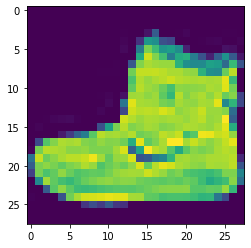

In [6]:
plt.imshow(Img[0][0].to(torch.device('cpu')).reshape(28,28));

In [7]:
ratio = 0.001
train, valid = torch.utils.data.random_split(Img, [int(len(Img)*(1 - ratio)), int(len(Img)*ratio)])

In [8]:
dataLoader = torch.utils.data.DataLoader(train, batch_size=500)

# MSE

In [9]:
def onehot(y):
    ret = torch.zeros(y.shape[0], 10)
    ret[torch.arange(y.shape[0]), y.long()] = 1
    return ret

In [43]:
def CE(y, y_pred):
    y = onehot(y) == 1
    return -torch.log(y_pred[y]).sum()# - torch.log(1 - y_pred[~y]).sum() + 0

# Means

In [22]:
def dist2(X, Y):
    Xsq = X.pow(2).sum(1, keepdim=True)
    Ysq = Y.pow(2).sum(1, keepdim=True)
    return Xsq + Ysq.T - 2*X @ Y.T

In [138]:
class Means(nn.Module):
    def __init__(self, input_size, output_size):
        super(Means, self).__init__()
        
        self.M = nn.Parameter(torch.randn(output_size, input_size))
    
    def forward(self, X, gamma=0.1):
        return torch.softmax(-gamma*dist2(X, self.M), 1)
    
    def forward_exp(self, X, gamma=0.001):
        return torch.softmax(torch.exp(-gamma*dist2(X, self.M)), 1)

In [83]:
model = Means(28*28, 10).to(cuda)

In [84]:
opt = optim.Adam(model.parameters())

In [131]:
EPOCHS = 100
for i in tnrange(EPOCHS):
    
    L_cum = 0
    
    for X, y in dataLoader:
        model.zero_grad()
        L = CE(y, model.forward(X.view(X.shape[0], 28*28))) # + C*sum([torch.sum(model.state_dict()[a]**2) if a[-1] == 't' else 0 for a in model.state_dict()])
        L.backward()
        L_cum += L
        opt.step()
        print(L)
    
    # Print
    if (i % (EPOCHS//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L_cum))
    i += 1

tensor(356.3442, device='cuda:0', grad_fn=<NegBackward>)
tensor(352.2035, device='cuda:0', grad_fn=<NegBackward>)
tensor(349.9740, device='cuda:0', grad_fn=<NegBackward>)
tensor(339.2188, device='cuda:0', grad_fn=<NegBackward>)
tensor(328.7634, device='cuda:0', grad_fn=<NegBackward>)
tensor(349.6596, device='cuda:0', grad_fn=<NegBackward>)
tensor(324.0327, device='cuda:0', grad_fn=<NegBackward>)
tensor(324.6228, device='cuda:0', grad_fn=<NegBackward>)
tensor(351.9519, device='cuda:0', grad_fn=<NegBackward>)
tensor(326.9797, device='cuda:0', grad_fn=<NegBackward>)
tensor(349.8179, device='cuda:0', grad_fn=<NegBackward>)
tensor(362.7170, device='cuda:0', grad_fn=<NegBackward>)
tensor(327.3952, device='cuda:0', grad_fn=<NegBackward>)
tensor(338.8341, device='cuda:0', grad_fn=<NegBackward>)
tensor(334.9642, device='cuda:0', grad_fn=<NegBackward>)
tensor(326.1271, device='cuda:0', grad_fn=<NegBackward>)
tensor(345.3392, device='cuda:0', grad_fn=<NegBackward>)
tensor(333.2317, device='cuda:0

tensor(332.7228, device='cuda:0', grad_fn=<NegBackward>)
tensor(319.5038, device='cuda:0', grad_fn=<NegBackward>)
tensor(341.4955, device='cuda:0', grad_fn=<NegBackward>)
tensor(313.1945, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.3492, device='cuda:0', grad_fn=<NegBackward>)
tensor(342.1485, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.9802, device='cuda:0', grad_fn=<NegBackward>)
tensor(342.5564, device='cuda:0', grad_fn=<NegBackward>)
tensor(356.6198, device='cuda:0', grad_fn=<NegBackward>)
tensor(319.7609, device='cuda:0', grad_fn=<NegBackward>)
tensor(330.1200, device='cuda:0', grad_fn=<NegBackward>)
tensor(324.9797, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.9411, device='cuda:0', grad_fn=<NegBackward>)
tensor(337.9739, device='cuda:0', grad_fn=<NegBackward>)
tensor(323.4422, device='cuda:0', grad_fn=<NegBackward>)
tensor(389.6459, device='cuda:0', grad_fn=<NegBackward>)
tensor(323.3167, device='cuda:0', grad_fn=<NegBackward>)
tensor(346.0687, device='cuda:0

tensor(304.2590, device='cuda:0', grad_fn=<NegBackward>)
tensor(308.6063, device='cuda:0', grad_fn=<NegBackward>)
tensor(335.3264, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.2853, device='cuda:0', grad_fn=<NegBackward>)
tensor(335.2181, device='cuda:0', grad_fn=<NegBackward>)
tensor(349.1665, device='cuda:0', grad_fn=<NegBackward>)
tensor(311.5276, device='cuda:0', grad_fn=<NegBackward>)
tensor(322.8301, device='cuda:0', grad_fn=<NegBackward>)
tensor(317.1592, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.7855, device='cuda:0', grad_fn=<NegBackward>)
tensor(330.4334, device='cuda:0', grad_fn=<NegBackward>)
tensor(314.6046, device='cuda:0', grad_fn=<NegBackward>)
tensor(382.5830, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.1011, device='cuda:0', grad_fn=<NegBackward>)
tensor(338.3214, device='cuda:0', grad_fn=<NegBackward>)
tensor(313.4494, device='cuda:0', grad_fn=<NegBackward>)
tensor(321.5547, device='cuda:0', grad_fn=<NegBackward>)
tensor(289.0046, device='cuda:0

tensor(302.4665, device='cuda:0', grad_fn=<NegBackward>)
tensor(328.7016, device='cuda:0', grad_fn=<NegBackward>)
tensor(342.4891, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.2033, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.3885, device='cuda:0', grad_fn=<NegBackward>)
tensor(310.2390, device='cuda:0', grad_fn=<NegBackward>)
tensor(303.5139, device='cuda:0', grad_fn=<NegBackward>)
tensor(323.7215, device='cuda:0', grad_fn=<NegBackward>)
tensor(306.7307, device='cuda:0', grad_fn=<NegBackward>)
tensor(376.1986, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.7744, device='cuda:0', grad_fn=<NegBackward>)
tensor(331.4079, device='cuda:0', grad_fn=<NegBackward>)
tensor(306.6784, device='cuda:0', grad_fn=<NegBackward>)
tensor(315.4455, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.5667, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.5938, device='cuda:0', grad_fn=<NegBackward>)
tensor(358.1460, device='cuda:0', grad_fn=<NegBackward>)
tensor(321.1905, device='cuda:0

tensor(297.6441, device='cuda:0', grad_fn=<NegBackward>)
tensor(310.6565, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.0818, device='cuda:0', grad_fn=<NegBackward>)
tensor(297.9811, device='cuda:0', grad_fn=<NegBackward>)
tensor(317.7107, device='cuda:0', grad_fn=<NegBackward>)
tensor(299.6762, device='cuda:0', grad_fn=<NegBackward>)
tensor(370.3923, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.1874, device='cuda:0', grad_fn=<NegBackward>)
tensor(325.1944, device='cuda:0', grad_fn=<NegBackward>)
tensor(300.5999, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.9982, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.8383, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.5955, device='cuda:0', grad_fn=<NegBackward>)
tensor(352.4183, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.3179, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.2666, device='cuda:0', grad_fn=<NegBackward>)
tensor(305.1817, device='cuda:0', grad_fn=<NegBackward>)
tensor(287.9376, device='cuda:0

tensor(293.0713, device='cuda:0', grad_fn=<NegBackward>)
tensor(312.2956, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.3236, device='cuda:0', grad_fn=<NegBackward>)
tensor(365.0836, device='cuda:0', grad_fn=<NegBackward>)
tensor(299.2206, device='cuda:0', grad_fn=<NegBackward>)
tensor(319.5778, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.1054, device='cuda:0', grad_fn=<NegBackward>)
tensor(305.1129, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.7073, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.1514, device='cuda:0', grad_fn=<NegBackward>)
tensor(347.2067, device='cuda:0', grad_fn=<NegBackward>)
tensor(311.9600, device='cuda:0', grad_fn=<NegBackward>)
tensor(289.9950, device='cuda:0', grad_fn=<NegBackward>)
tensor(299.8535, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.5881, device='cuda:0', grad_fn=<NegBackward>)
tensor(307.7032, device='cuda:0', grad_fn=<NegBackward>)
tensor(331.2039, device='cuda:0', grad_fn=<NegBackward>)
tensor(306.1200, device='cuda:0

tensor(360.2080, device='cuda:0', grad_fn=<NegBackward>)
tensor(294.7792, device='cuda:0', grad_fn=<NegBackward>)
tensor(314.4751, device='cuda:0', grad_fn=<NegBackward>)
tensor(290.1104, device='cuda:0', grad_fn=<NegBackward>)
tensor(300.7092, device='cuda:0', grad_fn=<NegBackward>)
tensor(267.0858, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.1832, device='cuda:0', grad_fn=<NegBackward>)
tensor(342.4409, device='cuda:0', grad_fn=<NegBackward>)
tensor(308.0300, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.2433, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.0500, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.8216, device='cuda:0', grad_fn=<NegBackward>)
tensor(302.9149, device='cuda:0', grad_fn=<NegBackward>)
tensor(326.1354, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.0371, device='cuda:0', grad_fn=<NegBackward>)
tensor(318.2427, device='cuda:0', grad_fn=<NegBackward>)
tensor(336.1989, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.1884, device='cuda:0

tensor(285.5465, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.7208, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.9028, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.6282, device='cuda:0', grad_fn=<NegBackward>)
tensor(338.0642, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.4592, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.9514, device='cuda:0', grad_fn=<NegBackward>)
tensor(290.6997, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.5651, device='cuda:0', grad_fn=<NegBackward>)
tensor(298.5800, device='cuda:0', grad_fn=<NegBackward>)
tensor(321.4852, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.3872, device='cuda:0', grad_fn=<NegBackward>)
tensor(313.5897, device='cuda:0', grad_fn=<NegBackward>)
tensor(330.8138, device='cuda:0', grad_fn=<NegBackward>)
tensor(288.9201, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.2263, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.8891, device='cuda:0', grad_fn=<NegBackward>)
tensor(312.8945, device='cuda:0

tensor(259.4357, device='cuda:0', grad_fn=<NegBackward>)
tensor(334.0292, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.1927, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.0687, device='cuda:0', grad_fn=<NegBackward>)
tensor(286.7427, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.7579, device='cuda:0', grad_fn=<NegBackward>)
tensor(294.6379, device='cuda:0', grad_fn=<NegBackward>)
tensor(317.1998, device='cuda:0', grad_fn=<NegBackward>)
tensor(292.1186, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.3037, device='cuda:0', grad_fn=<NegBackward>)
tensor(325.8146, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.0178, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.9654, device='cuda:0', grad_fn=<NegBackward>)
tensor(289.5655, device='cuda:0', grad_fn=<NegBackward>)
tensor(308.6698, device='cuda:0', grad_fn=<NegBackward>)
tensor(289.7343, device='cuda:0', grad_fn=<NegBackward>)
tensor(297.4400, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.4337, device='cuda:0

tensor(269.5530, device='cuda:0', grad_fn=<NegBackward>)
tensor(283.1292, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.3491, device='cuda:0', grad_fn=<NegBackward>)
tensor(291.0380, device='cuda:0', grad_fn=<NegBackward>)
tensor(313.2343, device='cuda:0', grad_fn=<NegBackward>)
tensor(288.1878, device='cuda:0', grad_fn=<NegBackward>)
tensor(305.3389, device='cuda:0', grad_fn=<NegBackward>)
tensor(321.1632, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.4329, device='cuda:0', grad_fn=<NegBackward>)
tensor(300.9993, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.5983, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.7404, device='cuda:0', grad_fn=<NegBackward>)
tensor(286.3168, device='cuda:0', grad_fn=<NegBackward>)
tensor(294.5434, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.0223, device='cuda:0', grad_fn=<NegBackward>)
tensor(304.5704, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.9047, device='cuda:0', grad_fn=<NegBackward>)
tensor(289.8566, device='cuda:0

tensor(287.7372, device='cuda:0', grad_fn=<NegBackward>)
tensor(309.5524, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.5577, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.6571, device='cuda:0', grad_fn=<NegBackward>)
tensor(316.8266, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.1260, device='cuda:0', grad_fn=<NegBackward>)
tensor(297.2950, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.9454, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.0730, device='cuda:0', grad_fn=<NegBackward>)
tensor(283.1310, device='cuda:0', grad_fn=<NegBackward>)
tensor(291.8926, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.9153, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.3399, device='cuda:0', grad_fn=<NegBackward>)
tensor(292.0548, device='cuda:0', grad_fn=<NegBackward>)
tensor(286.9092, device='cuda:0', grad_fn=<NegBackward>)
tensor(305.9064, device='cuda:0', grad_fn=<NegBackward>)
tensor(308.3950, device='cuda:0', grad_fn=<NegBackward>)
tensor(288.7845, device='cuda:0

tensor(298.2250, device='cuda:0', grad_fn=<NegBackward>)
tensor(312.7761, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.0638, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.8253, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.5709, device='cuda:0', grad_fn=<NegBackward>)
tensor(297.6395, device='cuda:0', grad_fn=<NegBackward>)
tensor(280.1495, device='cuda:0', grad_fn=<NegBackward>)
tensor(289.4568, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.0782, device='cuda:0', grad_fn=<NegBackward>)
tensor(298.3301, device='cuda:0', grad_fn=<NegBackward>)
tensor(288.4658, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.2045, device='cuda:0', grad_fn=<NegBackward>)
tensor(302.3450, device='cuda:0', grad_fn=<NegBackward>)
tensor(305.6883, device='cuda:0', grad_fn=<NegBackward>)
tensor(286.0742, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.2674, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.4763, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.6007, device='cuda:0

tensor(290.5662, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.4442, device='cuda:0', grad_fn=<NegBackward>)
tensor(294.4166, device='cuda:0', grad_fn=<NegBackward>)
tensor(277.3491, device='cuda:0', grad_fn=<NegBackward>)
tensor(287.2108, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.4808, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.5168, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.1107, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.7143, device='cuda:0', grad_fn=<NegBackward>)
tensor(299.0279, device='cuda:0', grad_fn=<NegBackward>)
tensor(303.1710, device='cuda:0', grad_fn=<NegBackward>)
tensor(283.5733, device='cuda:0', grad_fn=<NegBackward>)
tensor(298.1794, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.5513, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.6312, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.5698, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.1557, device='cuda:0', grad_fn=<NegBackward>)
tensor(300.1440, device='cuda:0

tensor(274.7101, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.1328, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.0975, device='cuda:0', grad_fn=<NegBackward>)
tensor(292.8793, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.9659, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.4151, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.9290, device='cuda:0', grad_fn=<NegBackward>)
tensor(300.8207, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.2578, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.3023, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.8506, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.8728, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.9575, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.6157, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.9166, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.6047, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.8822, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.1968, device='cuda:0

tensor(290.3997, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.0117, device='cuda:0', grad_fn=<NegBackward>)
tensor(277.2857, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.0254, device='cuda:0', grad_fn=<NegBackward>)
tensor(298.6186, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.1082, device='cuda:0', grad_fn=<NegBackward>)
tensor(292.6145, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.3513, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.3041, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.5085, device='cuda:0', grad_fn=<NegBackward>)
tensor(277.2481, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.9017, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.6077, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.4092, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.8402, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.7270, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.6846, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.9172, device='cuda:0

tensor(290.2968, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.5483, device='cuda:0', grad_fn=<NegBackward>)
tensor(277.1072, device='cuda:0', grad_fn=<NegBackward>)
tensor(290.0969, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.0329, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.9062, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.2089, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.0341, device='cuda:0', grad_fn=<NegBackward>)
tensor(291.0797, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.8054, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.0912, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.6846, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.7403, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.2831, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.7011, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.5046, device='cuda:0', grad_fn=<NegBackward>)
tensor(303.3193, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.9189, device='cuda:0

tensor(287.7336, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.8777, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.6624, device='cuda:0', grad_fn=<NegBackward>)
tensor(267.0461, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.9577, device='cuda:0', grad_fn=<NegBackward>)
tensor(288.4331, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.1795, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.9136, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.7133, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.9010, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.0206, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.6248, device='cuda:0', grad_fn=<NegBackward>)
tensor(277.3025, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.3409, device='cuda:0', grad_fn=<NegBackward>)
tensor(267.8014, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.0791, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.6526, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.5959, device='cuda:0

tensor(265.0090, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.0052, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.9466, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.7141, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.8638, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.9109, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.1946, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.8854, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.6759, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.2289, device='cuda:0', grad_fn=<NegBackward>)
tensor(299.4776, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.8102, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.8147, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.7757, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.6149, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.8254, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.0112, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.3182, device='cuda:0

tensor(258.3949, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.9304, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.2646, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.6086, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.8674, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.8437, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.2734, device='cuda:0', grad_fn=<NegBackward>)
tensor(297.7189, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.9341, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.6930, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.0058, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.7443, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.6826, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.0695, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.7812, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.6321, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.8560, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.2009, device='cuda:0

tensor(250.1321, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.9581, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.1186, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.4265, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.0554, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.1632, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.7012, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.3331, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.9758, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.6575, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.2333, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.3362, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.3811, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.0412, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.6856, device='cuda:0', grad_fn=<NegBackward>)
tensor(226.2209, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.7519, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.8347, device='cuda:0

tensor(269.6801, device='cuda:0', grad_fn=<NegBackward>)
tensor(294.4790, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.4893, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.8286, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.7493, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.3011, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.7405, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.4935, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.9733, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.2651, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.3372, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.3135, device='cuda:0', grad_fn=<NegBackward>)
tensor(224.7764, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.0116, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.7630, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.2935, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.6043, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.6672, device='cuda:0

tensor(236.0653, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.2470, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.7137, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.9230, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.8427, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.6848, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.2737, device='cuda:0', grad_fn=<NegBackward>)
tensor(231.7347, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.0734, device='cuda:0', grad_fn=<NegBackward>)
tensor(223.4150, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.3594, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.7863, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.7406, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.7132, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.9900, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.4140, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.8711, device='cuda:0', grad_fn=<NegBackward>)
tensor(201.6203, device='cuda:0

tensor(255.1971, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.2731, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.4633, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.3979, device='cuda:0', grad_fn=<NegBackward>)
tensor(230.2255, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.9555, device='cuda:0', grad_fn=<NegBackward>)
tensor(222.1295, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.7885, device='cuda:0', grad_fn=<NegBackward>)
tensor(267.8987, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.2694, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.9153, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.3845, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.4761, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.2887, device='cuda:0', grad_fn=<NegBackward>)
tensor(200.2121, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.3534, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.2343, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.9505, device='cuda:0

tensor(246.6296, device='cuda:0', grad_fn=<NegBackward>)
tensor(228.8022, device='cuda:0', grad_fn=<NegBackward>)
tensor(267.9509, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.9138, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.2921, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.0948, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.8738, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.2034, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.8459, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.6254, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.7871, device='cuda:0', grad_fn=<NegBackward>)
tensor(198.8752, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.7133, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.6813, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.3202, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.6441, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.8367, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.7789, device='cuda:0

tensor(219.7622, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.8645, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.3701, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.5477, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.5716, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.3696, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.8560, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.3596, device='cuda:0', grad_fn=<NegBackward>)
tensor(197.6053, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.1566, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.2144, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.7786, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.3597, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.5718, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.3282, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.4897, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.4841, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.6269, device='cuda:0

tensor(231.2863, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.0146, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.9519, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.1626, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.0002, device='cuda:0', grad_fn=<NegBackward>)
tensor(196.3978, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.6772, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.8269, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.3185, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.1454, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.3749, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.9560, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.1463, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.3366, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.1840, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.2065, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.1729, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.0247, device='cuda:0

tensor(259.5407, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.7035, device='cuda:0', grad_fn=<NegBackward>)
tensor(195.2487, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.2699, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.5128, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.9340, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.9958, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.2409, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.6559, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.8586, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.2427, device='cuda:0', grad_fn=<NegBackward>)
tensor(230.8088, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.5130, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.0236, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.7832, device='cuda:0', grad_fn=<NegBackward>)
tensor(303.0231, device='cuda:0', grad_fn=<NegBackward>)
tensor(234.4304, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.5096, device='cuda:0

tensor(260.9295, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.2667, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.6200, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.9063, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.1649, device='cuda:0', grad_fn=<NegBackward>)
tensor(231.4224, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.6226, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.1979, device='cuda:0', grad_fn=<NegBackward>)
tensor(229.4973, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.8913, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.9268, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.5918, device='cuda:0', grad_fn=<NegBackward>)
tensor(301.7586, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.9287, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.0829, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.5515, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.5914, device='cuda:0', grad_fn=<NegBackward>)
tensor(205.5822, device='cuda:0

tensor(268.8718, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.1421, device='cuda:0', grad_fn=<NegBackward>)
tensor(230.2500, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.4342, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.1989, device='cuda:0', grad_fn=<NegBackward>)
tensor(228.2456, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.3372, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.8782, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.4467, device='cuda:0', grad_fn=<NegBackward>)
tensor(300.5464, device='cuda:0', grad_fn=<NegBackward>)
tensor(231.4958, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.7181, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.4411, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.3797, device='cuda:0', grad_fn=<NegBackward>)
tensor(204.2481, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.3589, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.5201, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.1989, device='cuda:0

tensor(258.2903, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.2419, device='cuda:0', grad_fn=<NegBackward>)
tensor(227.0502, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.8464, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.8752, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.3447, device='cuda:0', grad_fn=<NegBackward>)
tensor(299.3829, device='cuda:0', grad_fn=<NegBackward>)
tensor(230.1268, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.4110, device='cuda:0', grad_fn=<NegBackward>)
tensor(234.3766, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.2149, device='cuda:0', grad_fn=<NegBackward>)
tensor(202.9760, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.2299, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.1829, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.0026, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.0408, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.3508, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.7087, device='cuda:0

tensor(247.4152, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.9146, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.2828, device='cuda:0', grad_fn=<NegBackward>)
tensor(298.2647, device='cuda:0', grad_fn=<NegBackward>)
tensor(228.8176, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.1580, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.3553, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.0941, device='cuda:0', grad_fn=<NegBackward>)
tensor(201.7617, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.1414, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.8978, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.8548, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.0521, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.3353, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.4884, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.6821, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.4450, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.9491, device='cuda:0

tensor(297.1890, device='cuda:0', grad_fn=<NegBackward>)
tensor(227.5638, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.9554, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.3742, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.0147, device='cuda:0', grad_fn=<NegBackward>)
tensor(200.6015, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.0912, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.6613, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.7524, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.1079, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.3615, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.3186, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.6599, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.2060, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.7547, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.5247, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.8066, device='cuda:0', grad_fn=<NegBackward>)
tensor(206.6374, device='cuda:0

tensor(231.4309, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.9735, device='cuda:0', grad_fn=<NegBackward>)
tensor(199.4918, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.0772, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.4703, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.6926, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.2049, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.4263, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.1967, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.6765, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.0156, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.6051, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.3668, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.5626, device='cuda:0', grad_fn=<NegBackward>)
tensor(205.7104, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.4579, device='cuda:0', grad_fn=<NegBackward>)
tensor(279.1619, device='cuda:0', grad_fn=<NegBackward>)
tensor(223.8257, device='cuda:0

tensor(250.0972, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.3223, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.6727, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.3411, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.5275, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.1193, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.7286, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.8708, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.4978, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.2542, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.3619, device='cuda:0', grad_fn=<NegBackward>)
tensor(204.8248, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.5848, device='cuda:0', grad_fn=<NegBackward>)
tensor(278.2854, device='cuda:0', grad_fn=<NegBackward>)
tensor(223.0316, device='cuda:0', grad_fn=<NegBackward>)
tensor(201.8156, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.7692, device='cuda:0', grad_fn=<NegBackward>)
tensor(219.5189, device='cuda:0

tensor(248.5146, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.6628, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.0841, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.8142, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.7691, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.4304, device='cuda:0', grad_fn=<NegBackward>)
tensor(255.1838, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.2014, device='cuda:0', grad_fn=<NegBackward>)
tensor(203.9775, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.7437, device='cuda:0', grad_fn=<NegBackward>)
tensor(277.4386, device='cuda:0', grad_fn=<NegBackward>)
tensor(222.2752, device='cuda:0', grad_fn=<NegBackward>)
tensor(200.7162, device='cuda:0', grad_fn=<NegBackward>)
tensor(283.8984, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.6303, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.6351, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.1303, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.3348, device='cuda:0

tensor(239.9309, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.7081, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.4006, device='cuda:0', grad_fn=<NegBackward>)
tensor(254.1530, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.0793, device='cuda:0', grad_fn=<NegBackward>)
tensor(203.1661, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.9324, device='cuda:0', grad_fn=<NegBackward>)
tensor(276.6201, device='cuda:0', grad_fn=<NegBackward>)
tensor(221.5536, device='cuda:0', grad_fn=<NegBackward>)
tensor(199.6638, device='cuda:0', grad_fn=<NegBackward>)
tensor(283.0600, device='cuda:0', grad_fn=<NegBackward>)
tensor(217.7765, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.6464, device='cuda:0', grad_fn=<NegBackward>)
tensor(219.1108, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.3829, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.3129, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.9013, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.4790, device='cuda:0

tensor(253.1596, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.9930, device='cuda:0', grad_fn=<NegBackward>)
tensor(202.3884, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.1494, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.8282, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.8644, device='cuda:0', grad_fn=<NegBackward>)
tensor(198.6563, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.2524, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.9550, device='cuda:0', grad_fn=<NegBackward>)
tensor(231.6913, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.1324, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.4624, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.4000, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.8928, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.5746, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.5934, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.9856, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.4057, device='cuda:0

tensor(244.3931, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.0617, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.2056, device='cuda:0', grad_fn=<NegBackward>)
tensor(197.6909, device='cuda:0', grad_fn=<NegBackward>)
tensor(281.4734, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.1650, device='cuda:0', grad_fn=<NegBackward>)
tensor(230.7681, device='cuda:0', grad_fn=<NegBackward>)
tensor(217.1924, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.5712, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.5210, device='cuda:0', grad_fn=<NegBackward>)
tensor(261.9190, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.7014, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.6783, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.2707, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.5762, device='cuda:0', grad_fn=<NegBackward>)
tensor(266.9507, device='cuda:0', grad_fn=<NegBackward>)
tensor(213.9323, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.2297, device='cuda:0

tensor(196.7654, device='cuda:0', grad_fn=<NegBackward>)
tensor(280.7218, device='cuda:0', grad_fn=<NegBackward>)
tensor(215.4044, device='cuda:0', grad_fn=<NegBackward>)
tensor(229.8754, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.2888, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.7085, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.6737, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.9786, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.8580, device='cuda:0', grad_fn=<NegBackward>)
tensor(283.7948, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.5805, device='cuda:0', grad_fn=<NegBackward>)
tensor(234.7790, device='cuda:0', grad_fn=<NegBackward>)
tensor(265.9023, device='cuda:0', grad_fn=<NegBackward>)
tensor(213.2091, device='cuda:0', grad_fn=<NegBackward>)
tensor(217.4897, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.0060, device='cuda:0', grad_fn=<NegBackward>)
tensor(253.4112, device='cuda:0', grad_fn=<NegBackward>)
tensor(297.1210, device='cuda:0

tensor(229.0117, device='cuda:0', grad_fn=<NegBackward>)
tensor(215.4193, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.8724, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.8562, device='cuda:0', grad_fn=<NegBackward>)
tensor(260.0700, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.0435, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.9415, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.9137, device='cuda:0', grad_fn=<NegBackward>)
tensor(234.0114, device='cuda:0', grad_fn=<NegBackward>)
tensor(264.8924, device='cuda:0', grad_fn=<NegBackward>)
tensor(212.5119, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.7786, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.0928, device='cuda:0', grad_fn=<NegBackward>)
tensor(252.6641, device='cuda:0', grad_fn=<NegBackward>)
tensor(296.1849, device='cuda:0', grad_fn=<NegBackward>)
tensor(223.6987, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.3351, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.4532, device='cuda:0

tensor(244.0674, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.1917, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.2568, device='cuda:0', grad_fn=<NegBackward>)
tensor(282.1169, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.2690, device='cuda:0', grad_fn=<NegBackward>)
tensor(233.2719, device='cuda:0', grad_fn=<NegBackward>)
tensor(263.9195, device='cuda:0', grad_fn=<NegBackward>)
tensor(211.8396, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.0959, device='cuda:0', grad_fn=<NegBackward>)
tensor(270.2075, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.9409, device='cuda:0', grad_fn=<NegBackward>)
tensor(295.2783, device='cuda:0', grad_fn=<NegBackward>)
tensor(222.9289, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.6601, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.6937, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.3228, device='cuda:0', grad_fn=<NegBackward>)
tensor(275.4359, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.6292, device='cuda:0

tensor(281.3195, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.6450, device='cuda:0', grad_fn=<NegBackward>)
tensor(232.5590, device='cuda:0', grad_fn=<NegBackward>)
tensor(262.9819, device='cuda:0', grad_fn=<NegBackward>)
tensor(211.1905, device='cuda:0', grad_fn=<NegBackward>)
tensor(215.4402, device='cuda:0', grad_fn=<NegBackward>)
tensor(269.3488, device='cuda:0', grad_fn=<NegBackward>)
tensor(251.2408, device='cuda:0', grad_fn=<NegBackward>)
tensor(294.3999, device='cuda:0', grad_fn=<NegBackward>)
tensor(222.1884, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.0062, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.9604, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.6367, device='cuda:0', grad_fn=<NegBackward>)
tensor(274.6675, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.8235, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.3685, device='cuda:0', grad_fn=<NegBackward>)
tensor(182.1873, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.5670, device='cuda:0

tensor(262.0779, device='cuda:0', grad_fn=<NegBackward>)
tensor(210.5634, device='cuda:0', grad_fn=<NegBackward>)
tensor(214.8105, device='cuda:0', grad_fn=<NegBackward>)
tensor(268.5152, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.5627, device='cuda:0', grad_fn=<NegBackward>)
tensor(293.5491, device='cuda:0', grad_fn=<NegBackward>)
tensor(221.4759, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.3724, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.2523, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.9747, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.9231, device='cuda:0', grad_fn=<NegBackward>)
tensor(250.0446, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.5839, device='cuda:0', grad_fn=<NegBackward>)
tensor(181.6931, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.8055, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.7470, device='cuda:0', grad_fn=<NegBackward>)
tensor(221.8055, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.3250, device='cuda:0

tensor(267.7057, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.9057, device='cuda:0', grad_fn=<NegBackward>)
tensor(292.7250, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.7903, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.7576, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.5677, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.3357, device='cuda:0', grad_fn=<NegBackward>)
tensor(273.2012, device='cuda:0', grad_fn=<NegBackward>)
tensor(249.2908, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.8248, device='cuda:0', grad_fn=<NegBackward>)
tensor(181.2188, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.0702, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.0007, device='cuda:0', grad_fn=<NegBackward>)
tensor(221.0196, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.6873, device='cuda:0', grad_fn=<NegBackward>)
tensor(226.6228, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.9790, device='cuda:0', grad_fn=<NegBackward>)
tensor(201.5414, device='cuda:0

tensor(220.1301, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.1616, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.9052, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.7190, device='cuda:0', grad_fn=<NegBackward>)
tensor(272.5009, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.5607, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.0908, device='cuda:0', grad_fn=<NegBackward>)
tensor(180.7632, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.3594, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.2804, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.2586, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.0722, device='cuda:0', grad_fn=<NegBackward>)
tensor(226.0481, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.2365, device='cuda:0', grad_fn=<NegBackward>)
tensor(200.8583, device='cuda:0', grad_fn=<NegBackward>)
tensor(214.8455, device='cuda:0', grad_fn=<NegBackward>)
tensor(248.0598, device='cuda:0', grad_fn=<NegBackward>)
tensor(220.0098, device='cuda:0

tensor(242.1236, device='cuda:0', grad_fn=<NegBackward>)
tensor(271.8215, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.8532, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.3801, device='cuda:0', grad_fn=<NegBackward>)
tensor(180.3258, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.6724, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.5847, device='cuda:0', grad_fn=<NegBackward>)
tensor(219.5212, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.4793, device='cuda:0', grad_fn=<NegBackward>)
tensor(225.4899, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.5166, device='cuda:0', grad_fn=<NegBackward>)
tensor(200.2008, device='cuda:0', grad_fn=<NegBackward>)
tensor(214.2216, device='cuda:0', grad_fn=<NegBackward>)
tensor(247.3160, device='cuda:0', grad_fn=<NegBackward>)
tensor(219.3990, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.2945, device='cuda:0', grad_fn=<NegBackward>)
tensor(259.2000, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.7027, device='cuda:0

tensor(234.6922, device='cuda:0', grad_fn=<NegBackward>)
tensor(179.9059, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.0078, device='cuda:0', grad_fn=<NegBackward>)
tensor(234.9124, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.8062, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.9069, device='cuda:0', grad_fn=<NegBackward>)
tensor(224.9475, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.8182, device='cuda:0', grad_fn=<NegBackward>)
tensor(199.5672, device='cuda:0', grad_fn=<NegBackward>)
tensor(213.6175, device='cuda:0', grad_fn=<NegBackward>)
tensor(246.5933, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.8073, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.6619, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.6176, device='cuda:0', grad_fn=<NegBackward>)
tensor(216.1609, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.4467, device='cuda:0', grad_fn=<NegBackward>)
tensor(228.9324, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.9471, device='cuda:0

tensor(234.2620, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.1128, device='cuda:0', grad_fn=<NegBackward>)
tensor(236.3547, device='cuda:0', grad_fn=<NegBackward>)
tensor(224.4196, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.1400, device='cuda:0', grad_fn=<NegBackward>)
tensor(198.9565, device='cuda:0', grad_fn=<NegBackward>)
tensor(213.0322, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.8906, device='cuda:0', grad_fn=<NegBackward>)
tensor(218.2335, device='cuda:0', grad_fn=<NegBackward>)
tensor(243.0492, device='cuda:0', grad_fn=<NegBackward>)
tensor(258.0533, device='cuda:0', grad_fn=<NegBackward>)
tensor(215.6373, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.9289, device='cuda:0', grad_fn=<NegBackward>)
tensor(228.3553, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.4911, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.7240, device='cuda:0', grad_fn=<NegBackward>)
tensor(211.6947, device='cuda:0', grad_fn=<NegBackward>)
tensor(286.2421, device='cuda:0

tensor(223.9055, device='cuda:0', grad_fn=<NegBackward>)
tensor(237.4812, device='cuda:0', grad_fn=<NegBackward>)
tensor(198.3671, device='cuda:0', grad_fn=<NegBackward>)
tensor(212.4644, device='cuda:0', grad_fn=<NegBackward>)
tensor(245.2074, device='cuda:0', grad_fn=<NegBackward>)
tensor(217.6773, device='cuda:0', grad_fn=<NegBackward>)
tensor(242.4557, device='cuda:0', grad_fn=<NegBackward>)
tensor(257.5065, device='cuda:0', grad_fn=<NegBackward>)
tensor(215.1299, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.4252, device='cuda:0', grad_fn=<NegBackward>)
tensor(227.7940, device='cuda:0', grad_fn=<NegBackward>)
tensor(235.0462, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.1860, device='cuda:0', grad_fn=<NegBackward>)
tensor(211.1330, device='cuda:0', grad_fn=<NegBackward>)
tensor(285.5869, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.7910, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.7119, device='cuda:0', grad_fn=<NegBackward>)
tensor(219.7387, device='cuda:0

tensor(211.9133, device='cuda:0', grad_fn=<NegBackward>)
tensor(244.5427, device='cuda:0', grad_fn=<NegBackward>)
tensor(217.1372, device='cuda:0', grad_fn=<NegBackward>)
tensor(241.8803, device='cuda:0', grad_fn=<NegBackward>)
tensor(256.9764, device='cuda:0', grad_fn=<NegBackward>)
tensor(214.6383, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.9349, device='cuda:0', grad_fn=<NegBackward>)
tensor(227.2476, device='cuda:0', grad_fn=<NegBackward>)
tensor(234.6126, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.6642, device='cuda:0', grad_fn=<NegBackward>)
tensor(210.5907, device='cuda:0', grad_fn=<NegBackward>)
tensor(284.9510, device='cuda:0', grad_fn=<NegBackward>)
tensor(238.3660, device='cuda:0', grad_fn=<NegBackward>)
tensor(239.0494, device='cuda:0', grad_fn=<NegBackward>)
tensor(219.1698, device='cuda:0', grad_fn=<NegBackward>)
tensor(240.9527, device='cuda:0', grad_fn=<NegBackward>)
tensor(208.3124, device='cuda:0', grad_fn=<NegBackward>)
tensor(197.4526, device='cuda:0

KeyboardInterrupt: 

In [ ]:
EPOCHS = 100
for i in tnrange(EPOCHS):
    
    model.zero_grad()
    
    L_cum = 0
    
    for X, y in dataLoader:
        L = CE(y, model.forward(X.view(X.shape[0], 28*28))) # + C*sum([torch.sum(model.state_dict()[a]**2) if a[-1] == 't' else 0 for a in model.state_dict()])
        L.backward()
        L_cum += L

    opt.step()
    
    # Print
    if (i % (EPOCHS//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L_cum))
    i += 1

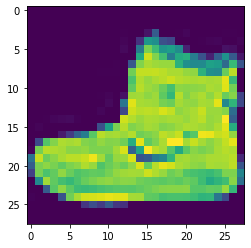

In [86]:
plt.imshow(Img[0][0].reshape(28,28).to(cpu))

In [87]:
Img[0][1]

tensor(9., device='cuda:0')

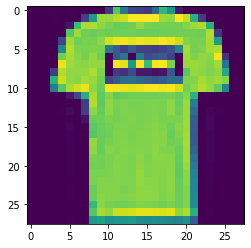

In [88]:
plt.imshow(Img[1][0].reshape(28,28).to(cpu))

In [132]:
model.M.data[0].reshape(28,28)

tensor([[ 8.0491e-01, -7.8900e-01,  1.6040e-01,  1.4068e+00, -2.3232e-01,
         -4.8291e-01,  5.4722e-01, -6.6573e-01, -7.1851e-01,  1.5105e+00,
         -1.8135e+00,  8.2868e-01,  1.1661e+00, -4.4597e-01, -1.1317e+00,
         -1.4638e+00,  3.4763e-02, -3.0855e-01,  2.7679e-01, -4.9594e-01,
          3.5244e-01, -7.6855e-01,  9.0077e-01, -7.4685e-01,  3.7933e-01,
          3.1782e-01,  2.3393e-01,  2.3004e-01],
        [-6.4379e-01, -1.0079e+00,  1.0929e-01, -7.6216e-01,  4.2450e-01,
         -1.0694e+00, -1.5439e+00,  2.1340e-01,  1.5352e+00, -1.4950e+00,
          1.5207e+00, -1.5179e+00,  1.0903e+00, -1.2706e-01,  4.5633e-01,
          1.8106e-01,  9.9203e-01,  2.2544e+00, -5.4693e-01,  1.2834e+00,
          5.8574e-01,  8.2765e-01, -9.1842e-01,  1.0675e+00,  1.5550e+00,
         -1.4020e+00, -1.2543e+00, -8.8953e-01],
        [-1.5125e-01, -5.2121e-01, -1.0372e+00, -8.5634e-01, -4.9132e-01,
          3.2788e-01,  6.2442e-02, -3.7124e-01, -6.4387e-01,  1.2127e+00,
          7.18

In [133]:
model.forward(X.reshape(X.shape[0], 28*28)).argmax(1) - y

tensor([ 0., -4., -4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., -4.,
         0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0.,  0.,
        -2.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0., -3.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -6., -2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0., -6., -6.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0., -4.,  0.,  0.,  0.,  0., -1.,  0., -4.,  0.,  0.,  0.,
         0.,  0.,  4.,  0.,  0.,  0.,  0., -2.,  0., -4.,  0.,  0.,  0., -2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  

In [134]:
Img[0][1]

tensor(9., device='cuda:0')

In [135]:
dist2(Img[0][0].reshape(1, 784), model.M)

tensor([[1157.1466, 1168.1936, 1138.8778, 1170.2325, 1134.3335, 1072.9115,
         1130.3877, 1068.8905, 1106.9232,  991.6725]], device='cuda:0',
       grad_fn=<SubBackward0>)

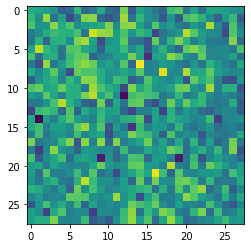

In [137]:
plt.imshow(model.M.data[6].reshape(28,28).to(cpu))

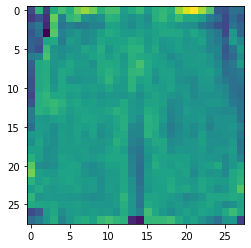

In [227]:
plt.imshow(list(model.parameters())[0].data[1].reshape(28,28).to(cpu))

In [222]:
list(model.parameters())[0].data[0] - list(model.parameters())[0].data[1]

tensor([-5.2598e-01,  1.3640e+00,  2.4233e+00,  1.8813e-01, -1.1545e+00,
        -8.6601e-01, -1.3209e+00, -1.3033e+00, -8.8189e-01, -1.0257e-01,
        -1.0007e+00, -2.4024e-01, -9.7519e-02, -9.1108e-01, -8.5237e-01,
        -4.9063e-01,  2.1873e-01, -2.4227e-01, -1.9793e-01, -1.1497e+00,
        -1.2466e+00, -2.4679e+00, -2.0479e+00, -1.3785e+00,  1.2963e+00,
         8.9295e-01, -4.2391e-01,  2.0765e+00,  1.8875e+00,  2.3116e+00,
         2.5894e+00, -2.7409e-01,  7.5132e-02, -1.2695e+00, -1.0254e+00,
         1.1009e-01,  3.0741e-01, -2.2586e-02, -4.4738e-01, -2.3375e-01,
        -1.2231e-01,  1.8598e-01,  2.1335e-01,  4.7178e-01, -2.5009e-01,
        -5.2562e-01, -1.9455e-01, -4.7169e-01,  1.1378e-01, -7.9530e-02,
        -5.1495e-01,  5.0680e-02,  9.0906e-01,  1.7674e+00, -2.5883e-02,
         2.5883e+00,  1.0841e+00, -3.6145e-01,  1.0916e+00,  5.7574e-02,
         7.0201e-01,  4.6851e-01,  4.5550e-01,  6.8461e-01,  5.2234e-01,
         3.2289e-01, -5.0550e-02, -1.2938e-01,  1.1

In [211]:
model.forward(X.reshape(X.shape[0], 28*28)).argmax(1) - y

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,
         0., -2.,  0.,  0., -4.,  0.,  4.,  0.,  0., -2., -4.,  0.,  0., -4.,
         0.,  0.,  0.,  3.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  2.,
         0.,  0.,  0.,  6.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  3., -5.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0., -2.,  0.,  0.,
        -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -2.,  0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  

In [135]:
model.forward(X.reshape(X.shape[0], 28*28)).max(1)[0].mean()

tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)